# A Deep CNN-Based model for COVID-19 Detection.¶

> M Amir Eshraghi

In [1]:
import os
import numpy as np # linear algebra
import shutil

In [2]:
!pip install imutils
from imutils import paths
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
import itertools



  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=8e91da6c8d22656273d0c91011e883cc2b91912c76c308a9e9eba830630dd723
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


**1- Data preparation**


In [3]:
data_dir  = '../input/covid19-delta-ct-14k'
data_list = sorted(list(paths.list_images(data_dir)))

random.seed(99)
random.shuffle(data_list)

In [4]:
#define
TEST_SIZE=0.14

#Split the data into two groups (training/validation and testing)
train_filenames, test_filenames = train_test_split(data_list, test_size=TEST_SIZE)

print('Number of Train/Valid data:',len(train_filenames))
print('Number of Test data ------:',len(test_filenames))

Number of Train/Valid data: 12454
Number of Test data ------: 2028


In [5]:
#Create Temporary folder and directories for data:

!mkdir /tmp/Covid_CT

!mkdir /tmp/Covid_CT/train_data
!mkdir /tmp/Covid_CT/train_data/COVID
!mkdir /tmp/Covid_CT/train_data/Non_COVID

!mkdir /tmp/Covid_CT/test_data
!mkdir /tmp/Covid_CT/test_data/COVID
!mkdir /tmp/Covid_CT/test_data/Non_COVID

!ls '/tmp/Covid_CT/train_data'

COVID  Non_COVID


In [6]:
#Pipeline: convert each image to grayscale for Homogenization, repeat the layer to
#prepare for base model as a RGB image and finally save them.

#train filenames:
f=0
for img in train_filenames: 
    i = cv2.imread(img)
    i = cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)        
    rgb = np.repeat(i[..., np.newaxis], 3, -1)      
    if (img.split(os.path.sep)[4] == 'COVID'):
        cv2.imwrite("/tmp/Covid_CT/train_data/COVID/p"+str(f)+".jpg",rgb)
    if (img.split(os.path.sep)[4] == 'Non_COVID'):
        cv2.imwrite("/tmp/Covid_CT/train_data/Non_COVID/n"+str(f)+".jpg",rgb)
    f+=1  
#test filenames:
f=0
for img in test_filenames: 
    i = cv2.imread(img)
    i = cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)
    rgb = np.repeat(i[..., np.newaxis], 3, -1)      
    if (img.split(os.path.sep)[4] == 'COVID'):
        cv2.imwrite("/tmp/Covid_CT/test_data/COVID/p"+str(f)+".jpg",rgb)
    if (img.split(os.path.sep)[4] == 'Non_COVID'):
        cv2.imwrite("/tmp/Covid_CT/test_data/Non_COVID/n"+str(f)+".jpg",rgb)
    f+=1

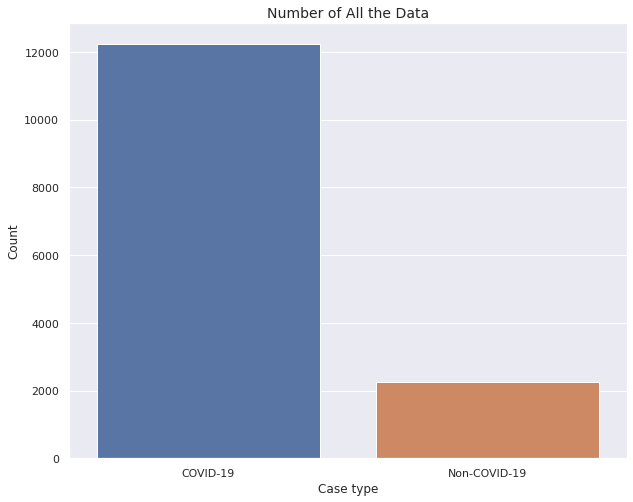

          Cases  Cases_count
0      COVID-19        12231
1  Non-COVID-19         2251


In [8]:
#print the number of all the data:

COUNT_COVID= len(list(paths.list_images('/tmp/Covid_CT/train_data/COVID'))) + len(list(paths.list_images('/tmp/Covid_CT/test_data/COVID')))
COUNT_Non_COVID= len(list(paths.list_images('/tmp/Covid_CT/train_data/Non_COVID'))) + len(list(paths.list_images('/tmp/Covid_CT/test_data/Non_COVID')))

data = {'Cases':['COVID-19', 'Non-COVID-19'],
        'Cases_count':[COUNT_COVID, COUNT_Non_COVID]
       }

df = pd.DataFrame(data)

sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.barplot(x=df.index, y= df['Cases_count'].values)
plt.title('Number of All the Data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(df.index)), ['COVID-19', 'Non-COVID-19'])
plt.show()

print(df)

In [10]:
#print the details of each directory:

print('Number of train images :',len(list(paths.list_images('/tmp/Covid_CT/train_data'))))
print('Covid-19 ------------- :',len(list(paths.list_images('/tmp/Covid_CT/train_data/COVID'))))
print('Non-Covid-19 --------- :',len(list(paths.list_images('/tmp/Covid_CT/train_data/Non_COVID'))))
print('\n')
print('Number of test images :',len(list(paths.list_images('/tmp/Covid_CT/test_data'))))
print('Covid-19 ------------ :',len(list(paths.list_images('/tmp/Covid_CT/test_data/COVID'))))
print('Non-Covid-19 -------- :',len(list(paths.list_images('/tmp/Covid_CT/test_data/Non_COVID'))))

Number of train images : 12454
Covid-19 ------------- : 10521
Non-Covid-19 --------- : 1933


Number of test images : 2028
Covid-19 ------------ : 1710
Non-Covid-19 -------- : 318


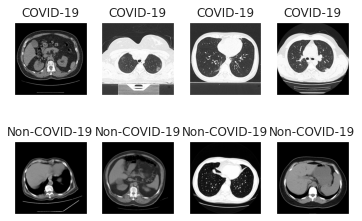

In [16]:
#create sample data and show them:

sample_imgs=[]
sample_labels=[]

tmp = sorted(list(paths.list_images('/tmp/Covid_CT/train_data/COVID')))
random.shuffle(tmp)
for X in tmp[:4]:
    sample_imgs.append(cv2.imread(X))
    sample_labels.append('COVID-19')
        
tmp = sorted(list(paths.list_images('/tmp/Covid_CT/train_data/Non_COVID')))
random.shuffle(tmp)
for X in tmp[:4]:
    sample_imgs.append(cv2.imread(X))
    sample_labels.append('Non-COVID-19')     


for i in range(0, 8):
    plt.subplot(2 , 4 , i+1)
    plt.imshow(sample_imgs[i+0])
    plt.title(sample_labels[i+0])
    plt.xticks([]),plt.yticks([])
    # show the plot
plt.show()

#sample_imgs = np.asarray(sample_imgs)
#print(sample_imgs.shape)

**2- Create pre-processing and augmentation pipeline**


In [17]:
#set the directories 
TRAIN_DATA_DIR = "/tmp/Covid_CT/train_data"
TEST_DATA_DIR  = "/tmp/Covid_CT/test_data"

In [18]:
#defines 

IMG_HIGHT, IMG_WIDTH = 255,255
BATCH_SIZE = 32
VALID_SPLIT = 0.17

In [19]:
#set the Pipeline with ImageDataGenerator(real-time data augmentation)
datagen = ImageDataGenerator(validation_split= VALID_SPLIT,      #Split Validation
                             rescale=1./255,                    #Rescale to float
                             #featurewise_center=True,
                             #featurewise_std_normalization=True, 
                             samplewise_center=True,            #Set each sample mean to 0.
                             samplewise_std_normalization=True, #Divide each input by its std. 
                             vertical_flip=True,                #Augmentation
                             horizontal_flip=True,              #Augmentation
                             rotation_range=30                  #Augmentation,random rotations.
)
#datagen.fit(sample_imgs)
#print(datagen.mean)
#print(datagen.std)

In [20]:
#set the Training and Vaidation Generators:

TRAIN_GEN = datagen.flow_from_directory(
            TRAIN_DATA_DIR,
            target_size=(IMG_HIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            subset='training',
            shuffle=True,
            #color_mode="grayscale",
            seed=99
)
VALID_GEN = datagen.flow_from_directory(
            TRAIN_DATA_DIR,
            target_size=(IMG_HIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            subset='validation',
            shuffle=True,
            #color_mode="grayscale",
            seed=99
)

Found 10338 images belonging to 2 classes.
Found 2116 images belonging to 2 classes.


32


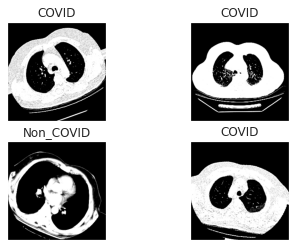

In [21]:
#Show random picture after the Augmentation and Normalization:

for X_batch, y_batch in TRAIN_GEN:
    print(len(y_batch))
    # create a grid of 3x3 images
    for i in range(0, 4):
        plt.subplot(2 , 2 , i+1)
        plt.imshow(X_batch[i])
        plt.title('COVID' if y_batch[i]==0 else 'Non_COVID')
        plt.xticks([]),plt.yticks([])
    # show the plot
    plt.show()
    break

In [22]:
#create the pipeline and generator for Test data:

t_datagen = ImageDataGenerator(rescale=1./255,
                               #featurewise_center=True,
                               #featurewise_std_normalization=True
                               samplewise_std_normalization=True,
                               samplewise_center=True
)

TEST_GEN = t_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_HIGHT, IMG_WIDTH),
    batch_size=2028,
    class_mode='binary',
    shuffle=True,
    seed=99
)

Found 2028 images belonging to 2 classes.


**3- Create the Model**



In [23]:
#defines:

LEARNING_RATE = 0.00001
EPOCHS = 30
LOSS = 'sparse_categorical_crossentropy'
METRIC = 'accuracy'

In [25]:
#set the model:

base = tf.keras.applications.resnet.ResNet152(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_HIGHT, IMG_WIDTH, 3)
)

x = base.output

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(128, activation='relu',kernel_initializer='he_uniform')(x)
y = tf.keras.layers.Dropout(0.3)(x)

prediction = tf.keras.layers.Dense(2, activation='softmax')(y)

model = Model(inputs= base.input, outputs= prediction)
#model.summary()

In [26]:
#Compile the model:

model.compile(optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              loss      = LOSS,
              metrics   = [METRIC])

In [27]:
STEP_SIZE_TRAIN=TRAIN_GEN.n//TRAIN_GEN.batch_size
print('full steps number:', STEP_SIZE_TRAIN)

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5) #early stopping

full steps number: 323


In [28]:
#Train the model:

trainer= model.fit(TRAIN_GEN,
                   validation_data= VALID_GEN,
                   epochs=EPOCHS,
                   steps_per_epoch=300,
                   verbose=2,
                   callbacks=[early])

2021-10-20 08:47:05.235904: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-10-20 08:47:23.127700: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


300/300 - 297s - loss: 0.5147 - accuracy: 0.8635 - val_loss: 2.0394 - val_accuracy: 0.2741
Epoch 2/30
300/300 - 269s - loss: 0.3229 - accuracy: 0.9507 - val_loss: 1.8058 - val_accuracy: 0.4017
Epoch 3/30
300/300 - 269s - loss: 0.2730 - accuracy: 0.9702 - val_loss: 0.8884 - val_accuracy: 0.6654
Epoch 4/30
300/300 - 269s - loss: 0.2566 - accuracy: 0.9767 - val_loss: 0.5368 - val_accuracy: 0.8346
Epoch 5/30
300/300 - 268s - loss: 0.2451 - accuracy: 0.9793 - val_loss: 0.2693 - val_accuracy: 0.9664
Epoch 6/30
300/300 - 269s - loss: 0.2257 - accuracy: 0.9851 - val_loss: 0.2027 - val_accuracy: 0.9920
Epoch 7/30
300/300 - 269s - loss: 0.2186 - accuracy: 0.9875 - val_loss: 0.1994 - val_accuracy: 0.9939
Epoch 8/30
300/300 - 273s - loss: 0.2114 - accuracy: 0.9901 - val_loss: 0.1948 - val_accuracy: 0.9953
Epoch 9/30
300/300 - 270s - loss: 0.2095 - accuracy: 0.9903 - val_loss: 0.1916 - val_accuracy: 0.9948
Epoch 10/30
300/300 - 271s - loss: 0.2028 - accuracy: 0.9937 - val_loss: 0.2026 - val_accurac

**4- Results**

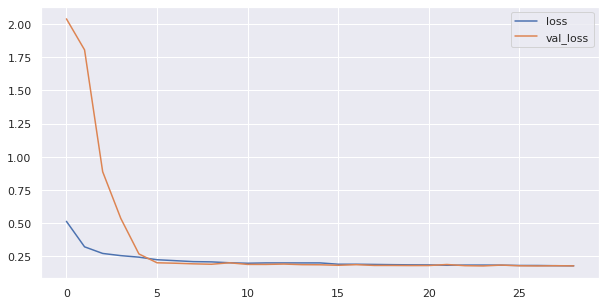

In [29]:
# Plotting train_loss vs val_loss:

plt.figure(figsize=(10,5))
plt.plot(trainer.history["loss"],label="loss")
plt.plot(trainer.history["val_loss"],label="val_loss")
plt.legend()

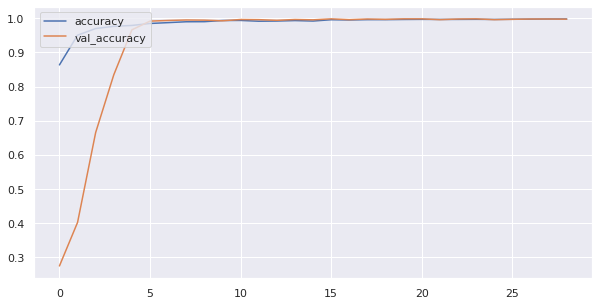

In [30]:
# Plotting train_accuracy vs Val_accuracy:

plt.figure(figsize=(10,5))
plt.plot(trainer.history["accuracy"],label="accuracy")
plt.plot(trainer.history["val_accuracy"],label="val_accuracy")
plt.legend(loc='upper left')

In [31]:
for X_batch, y_batch in TEST_GEN:
    y_test = y_batch
    X_test = X_batch
    break
    
print('test label shape',y_test.shape)
print('test image shape',X_test.shape)
print('Evaluate on test-data:')
model.evaluate(X_test,y_test)

test label shape (2028,)
test image shape (2028, 255, 255, 3)
Evaluate on test-data:


2021-10-20 11:29:51.622140: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1582448400 exceeds 10% of free system memory.
2021-10-20 11:29:53.355366: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1582448400 exceeds 10% of free system memory.


64/64 [==============================] - 13s 169ms/step - loss: 0.1820 - accuracy: 0.9970


[0.18198533356189728, 0.9970414042472839]

In [32]:
pred = model.predict(X_test)
bin_predict = np.argmax(pred,axis=1)

#Confusion matrix:
matrix = confusion_matrix(y_test, bin_predict)
print('Confusion Matrix:\n',matrix)

2021-10-20 11:30:12.083820: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1582448400 exceeds 10% of free system memory.
2021-10-20 11:30:13.842872: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1582448400 exceeds 10% of free system memory.


Confusion Matrix:
 [[1706    4]
 [   2  316]]


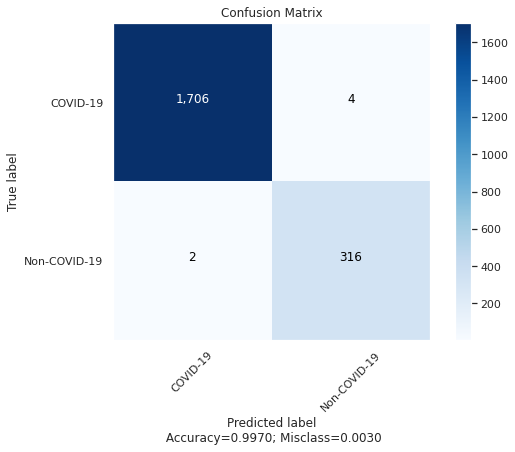

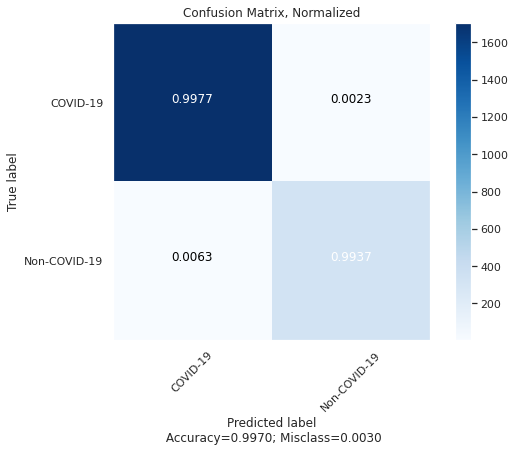

In [33]:
#Plot the Confusion matrix:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    sns.set(style="dark")
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n Accuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

    
plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = False,
                      target_names = ['COVID-19','Non-COVID-19'],
                      title        = "Confusion Matrix")

plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = True,
                      target_names = ['COVID-19','Non-COVID-19'],
                      title        = "Confusion Matrix, Normalized")

In [34]:
class_metrics = metrics.classification_report(y_test,bin_predict,labels=[0, 1])
print(class_metrics)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1710
           1       0.99      0.99      0.99       318

    accuracy                           1.00      2028
   macro avg       0.99      1.00      0.99      2028
weighted avg       1.00      1.00      1.00      2028



In [35]:
FP = matrix.sum(axis=0) - np.diag(matrix)
FN = matrix.sum(axis=1) - np.diag(matrix)
TP = np.diag(matrix)
TN = matrix[:].sum() - (FP + FN + TP)

TPR = TP/(TP+FN)
TNR = TN/(TN+FP) 
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
FPR = FP/(FP+TN)
FNR = FN/(TP+FN)
FDR = FP/(TP+FP)

ACC = (TP+TN)/(TP+FP+FN+TN)

print('Other Metrics:')
MAE = mean_absolute_error(y_test, bin_predict)

print('MAE:', MAE)
print('Accuracy:', ACC)
print('Precision (positive predictive value):', PPV)
print('Recall (Sensitivity, hit rate, true positive rate):', TPR)
print('Specificity (true negative rate):', TNR)
print('Negative Predictive Value:', NPV)
print('Fall out (false positive rate):', FPR)
print('False Negative Rate:', FNR)
print('False discovery rate:', FDR)

Other Metrics:
MAE: 0.0029585798816568047
Accuracy: [0.99704142 0.99704142]
Precision (positive predictive value): [0.99882904 0.9875    ]
Recall (Sensitivity, hit rate, true positive rate): [0.99766082 0.99371069]
Specificity (true negative rate): [0.99371069 0.99766082]
Negative Predictive Value: [0.9875     0.99882904]
Fall out (false positive rate): [0.00628931 0.00233918]
False Negative Rate: [0.00233918 0.00628931]
False discovery rate: [0.00117096 0.0125    ]


In [36]:
model.save_weights('weights_MLP.h5')


Deep CNN-Based for COVID-19 Detection Using Multiple Lung CT Scans. (Classes: Covid-19, Non-Covid-19)

© Proposed Method Implementation by **M Amir Eshraghi**.

This code is part of the new study and the the article will be referenced after the publication.

Oct 2021 / Mashhad, Iran.
